# Project Statement


Sentiment Analysis of Movie Reviews Using Traditional NLP Models

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In this section of the project, I started by importing the necessary Python libraries like NumPy, pandas, Matplotlib, Seaborn, and a few others that I needed for working with data and creating visualizations. I also included tqdm so I could track the progress of loops if needed later. After setting the plotting style to Seaborn and configuring inline settings for better display quality, I loaded the dataset using pd.read_csv(). The dataset I used is a tab-separated file called imdb_reviews.tsv, which contains movie and review information. I specifically told pandas to treat the "votes" column as integers. After loading the data, I used .head() to preview the first few rows and confirm that everything loaded correctly. The dataset includes columns like title, year, genres, average rating, review text, and sentiment labels (pos for positive and neg for negative), which are key for the sentiment analysis I’ll be performing throughout the project.

## EDA

Let's check the number of movies and reviews over years.

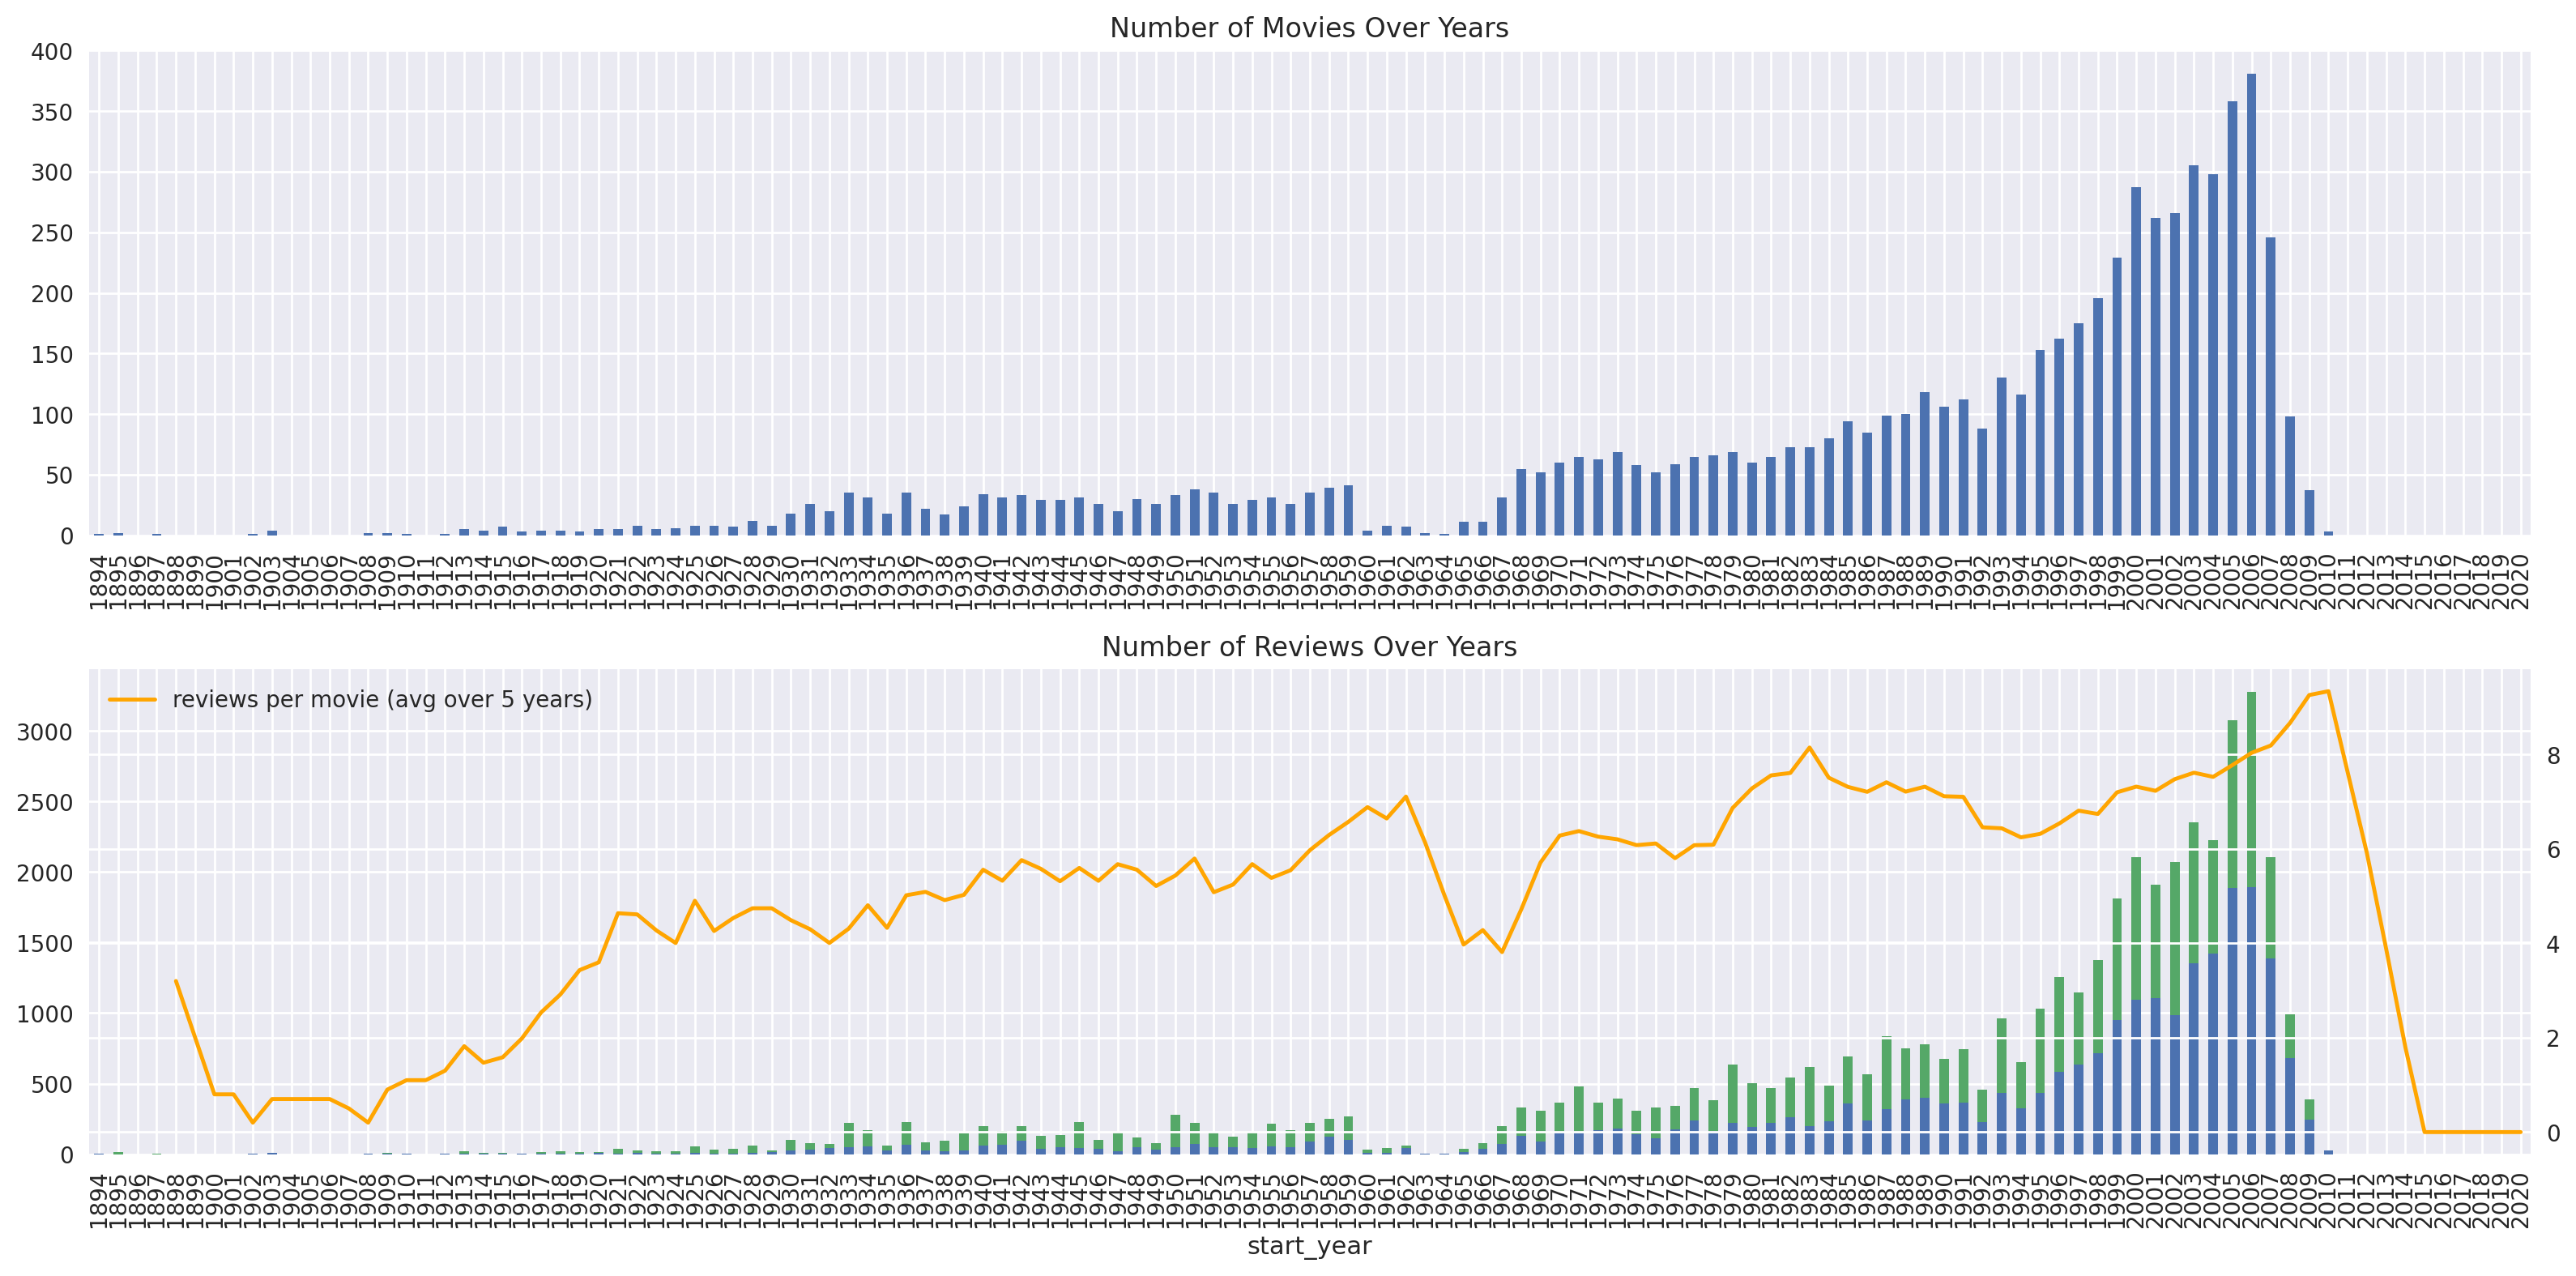

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

In this part of the project, I performed exploratory data analysis (EDA) to explore how movie production and reviews have changed over time. I created two subplots: the first one shows the number of movies released each year, and the second one shows the number of reviews per year along with the average number of reviews per movie (calculated using a rolling mean over 5 years). To do this, I first counted the unique movie titles by year and plotted that data as a bar chart. Then, for the second chart, I counted the number of reviews each year, separated by sentiment (positive and negative), and visualized it as a stacked bar chart. I also calculated the average reviews per movie to understand how review activity has changed over time, and added that as an orange line on the same chart. This helped me see trends like how more movies and reviews started appearing after the 2000s and how engagement grew until recently.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

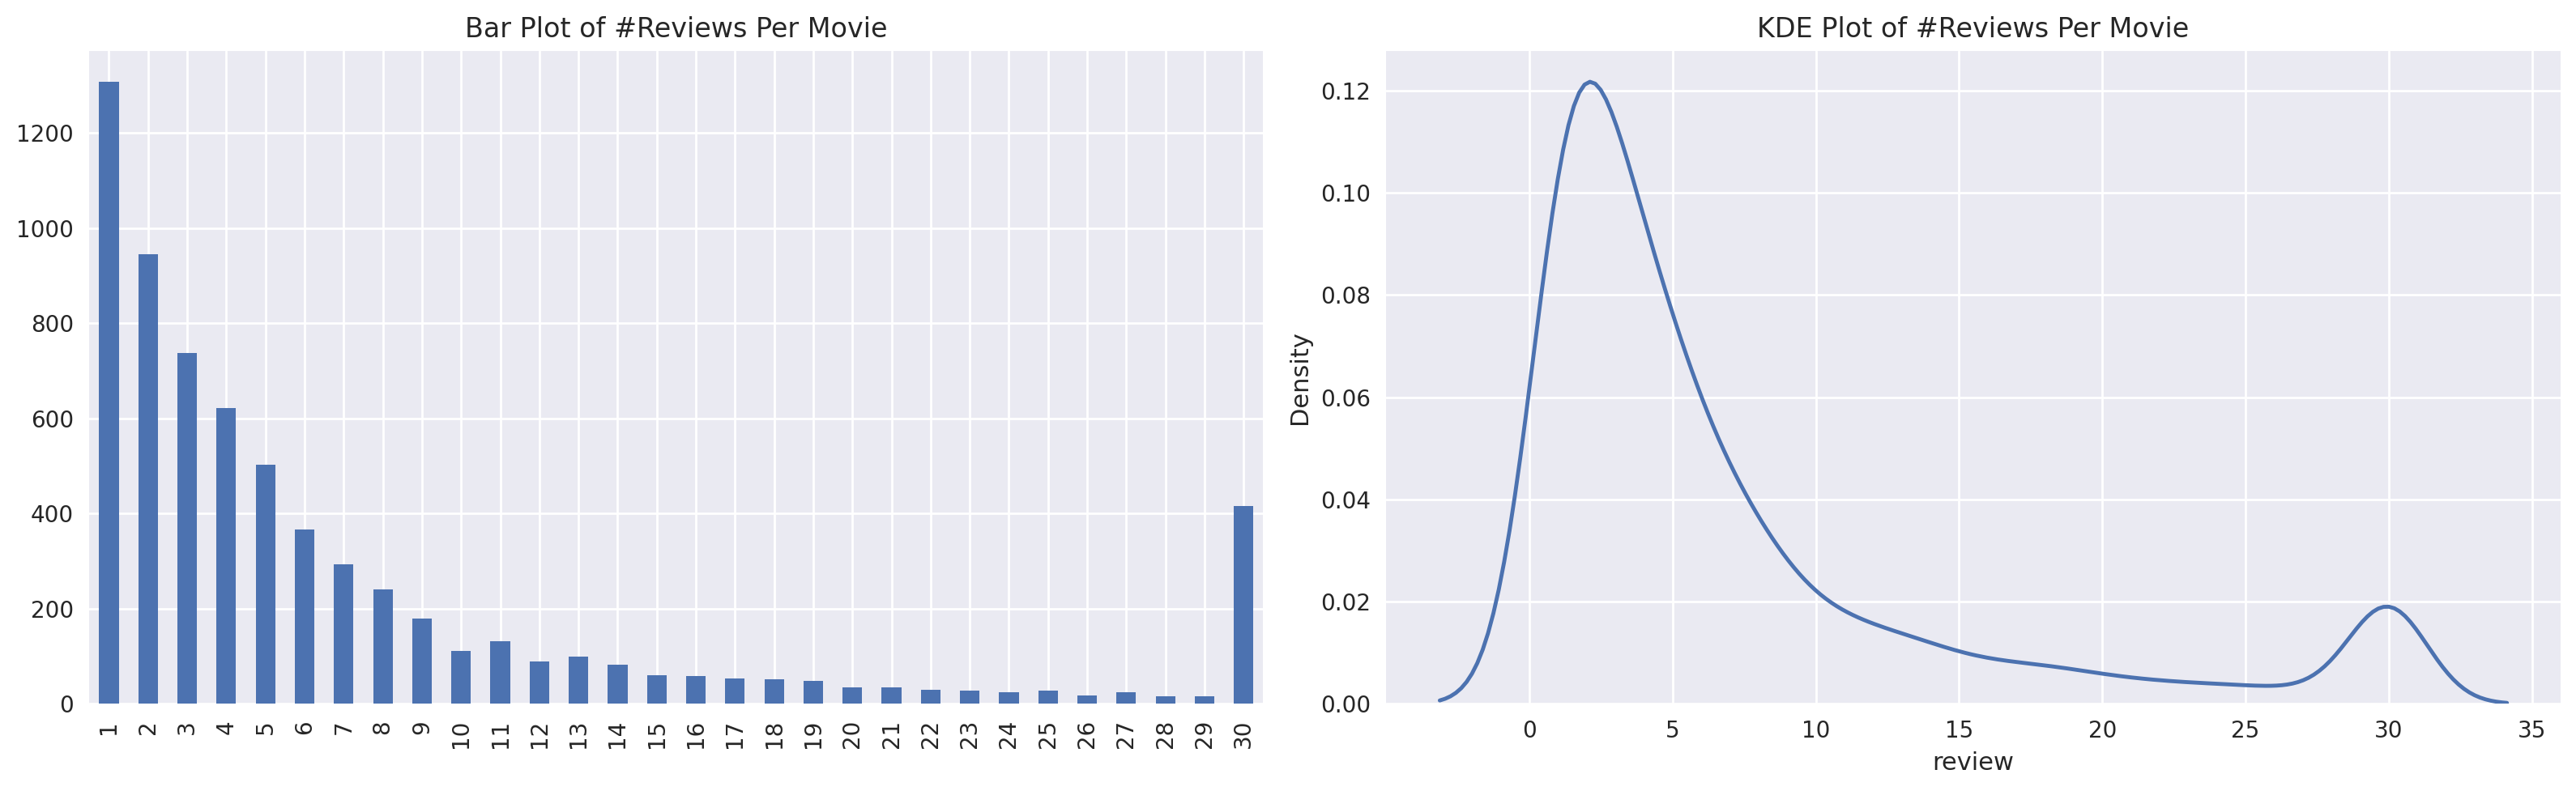

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

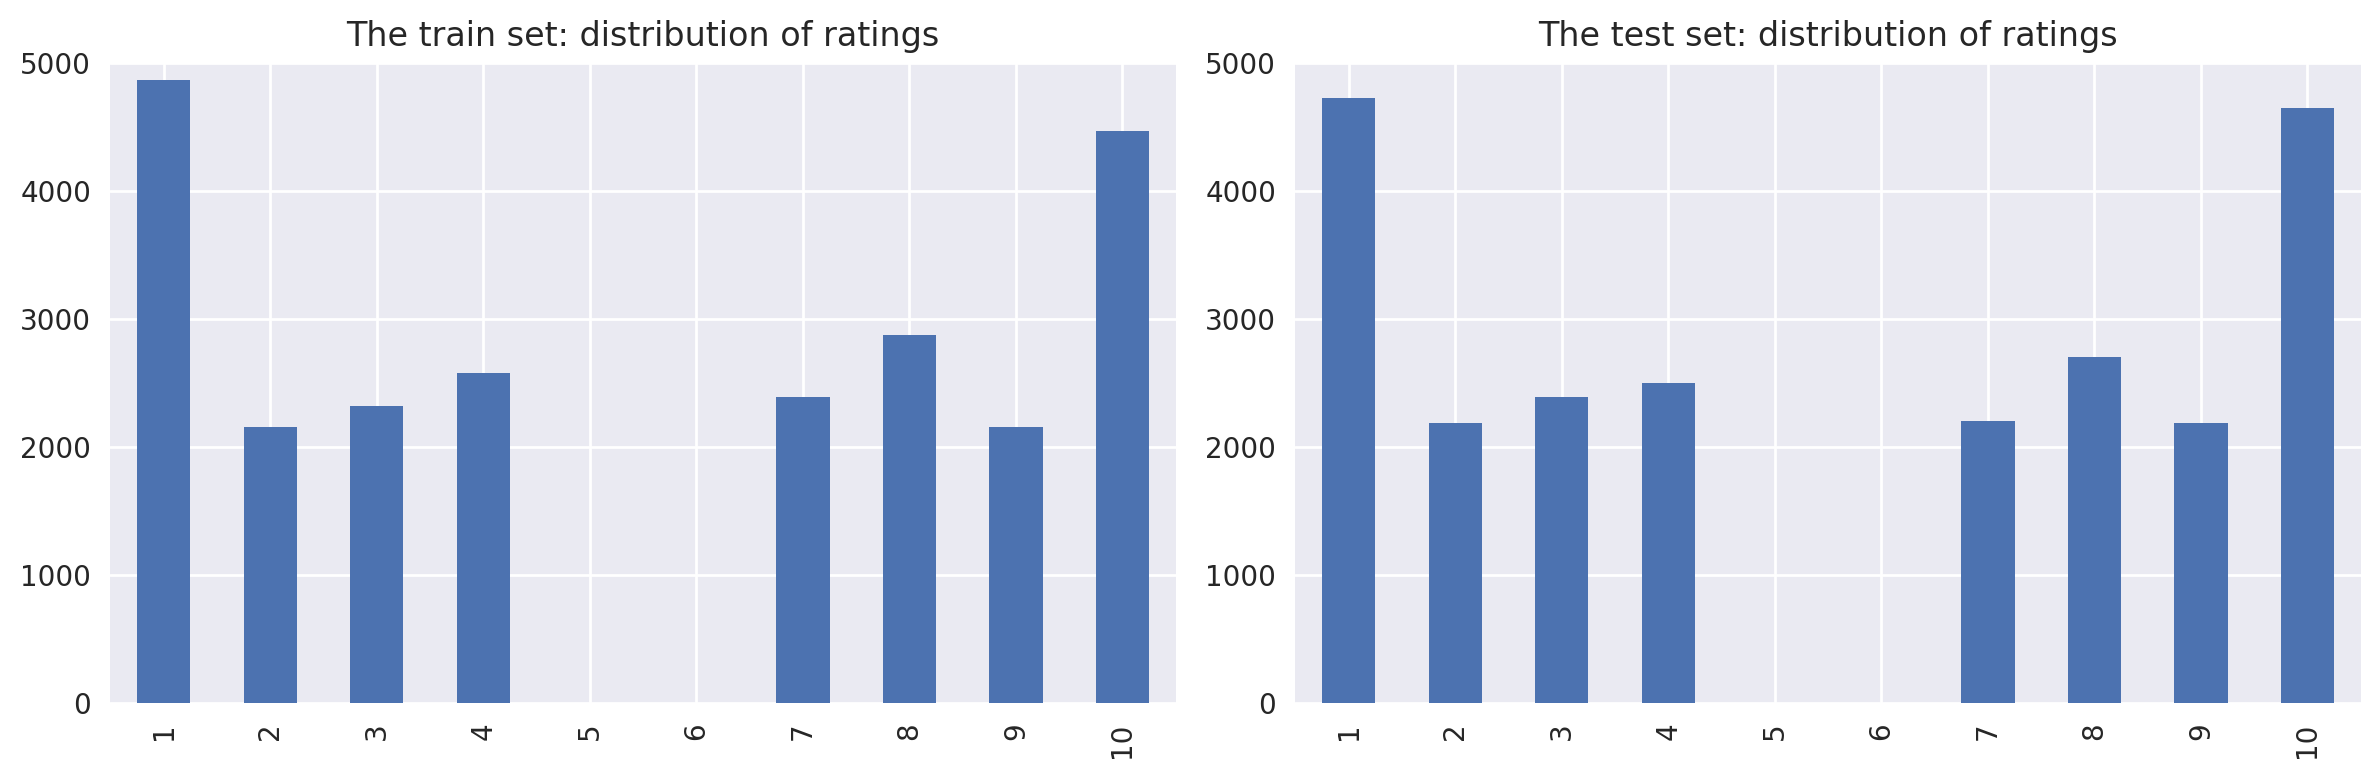

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In this section of my analysis, I explored the distribution of the number of reviews each movie received and how ratings were spread across the train and test sets. I started by creating two visualizations to look at the number of reviews per movie: a bar plot and a KDE (kernel density estimate) plot. The bar plot gave me the actual counts of how many movies received a certain number of reviews, while the KDE plot showed a smoothed-out version of that distribution. It helped me see that most movies tend to get only a few reviews, with fewer movies receiving lots of them. Next, I checked the balance between positive and negative reviews, which turned out to be pretty even. Then I created two bar charts to visualize the distribution of review ratings for both the training and test sets. This helped me verify that both sets had a similar range and frequency of ratings, which is important for making sure my models can generalize well.

Distribution of negative and positive reviews over the years for two parts of the dataset

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


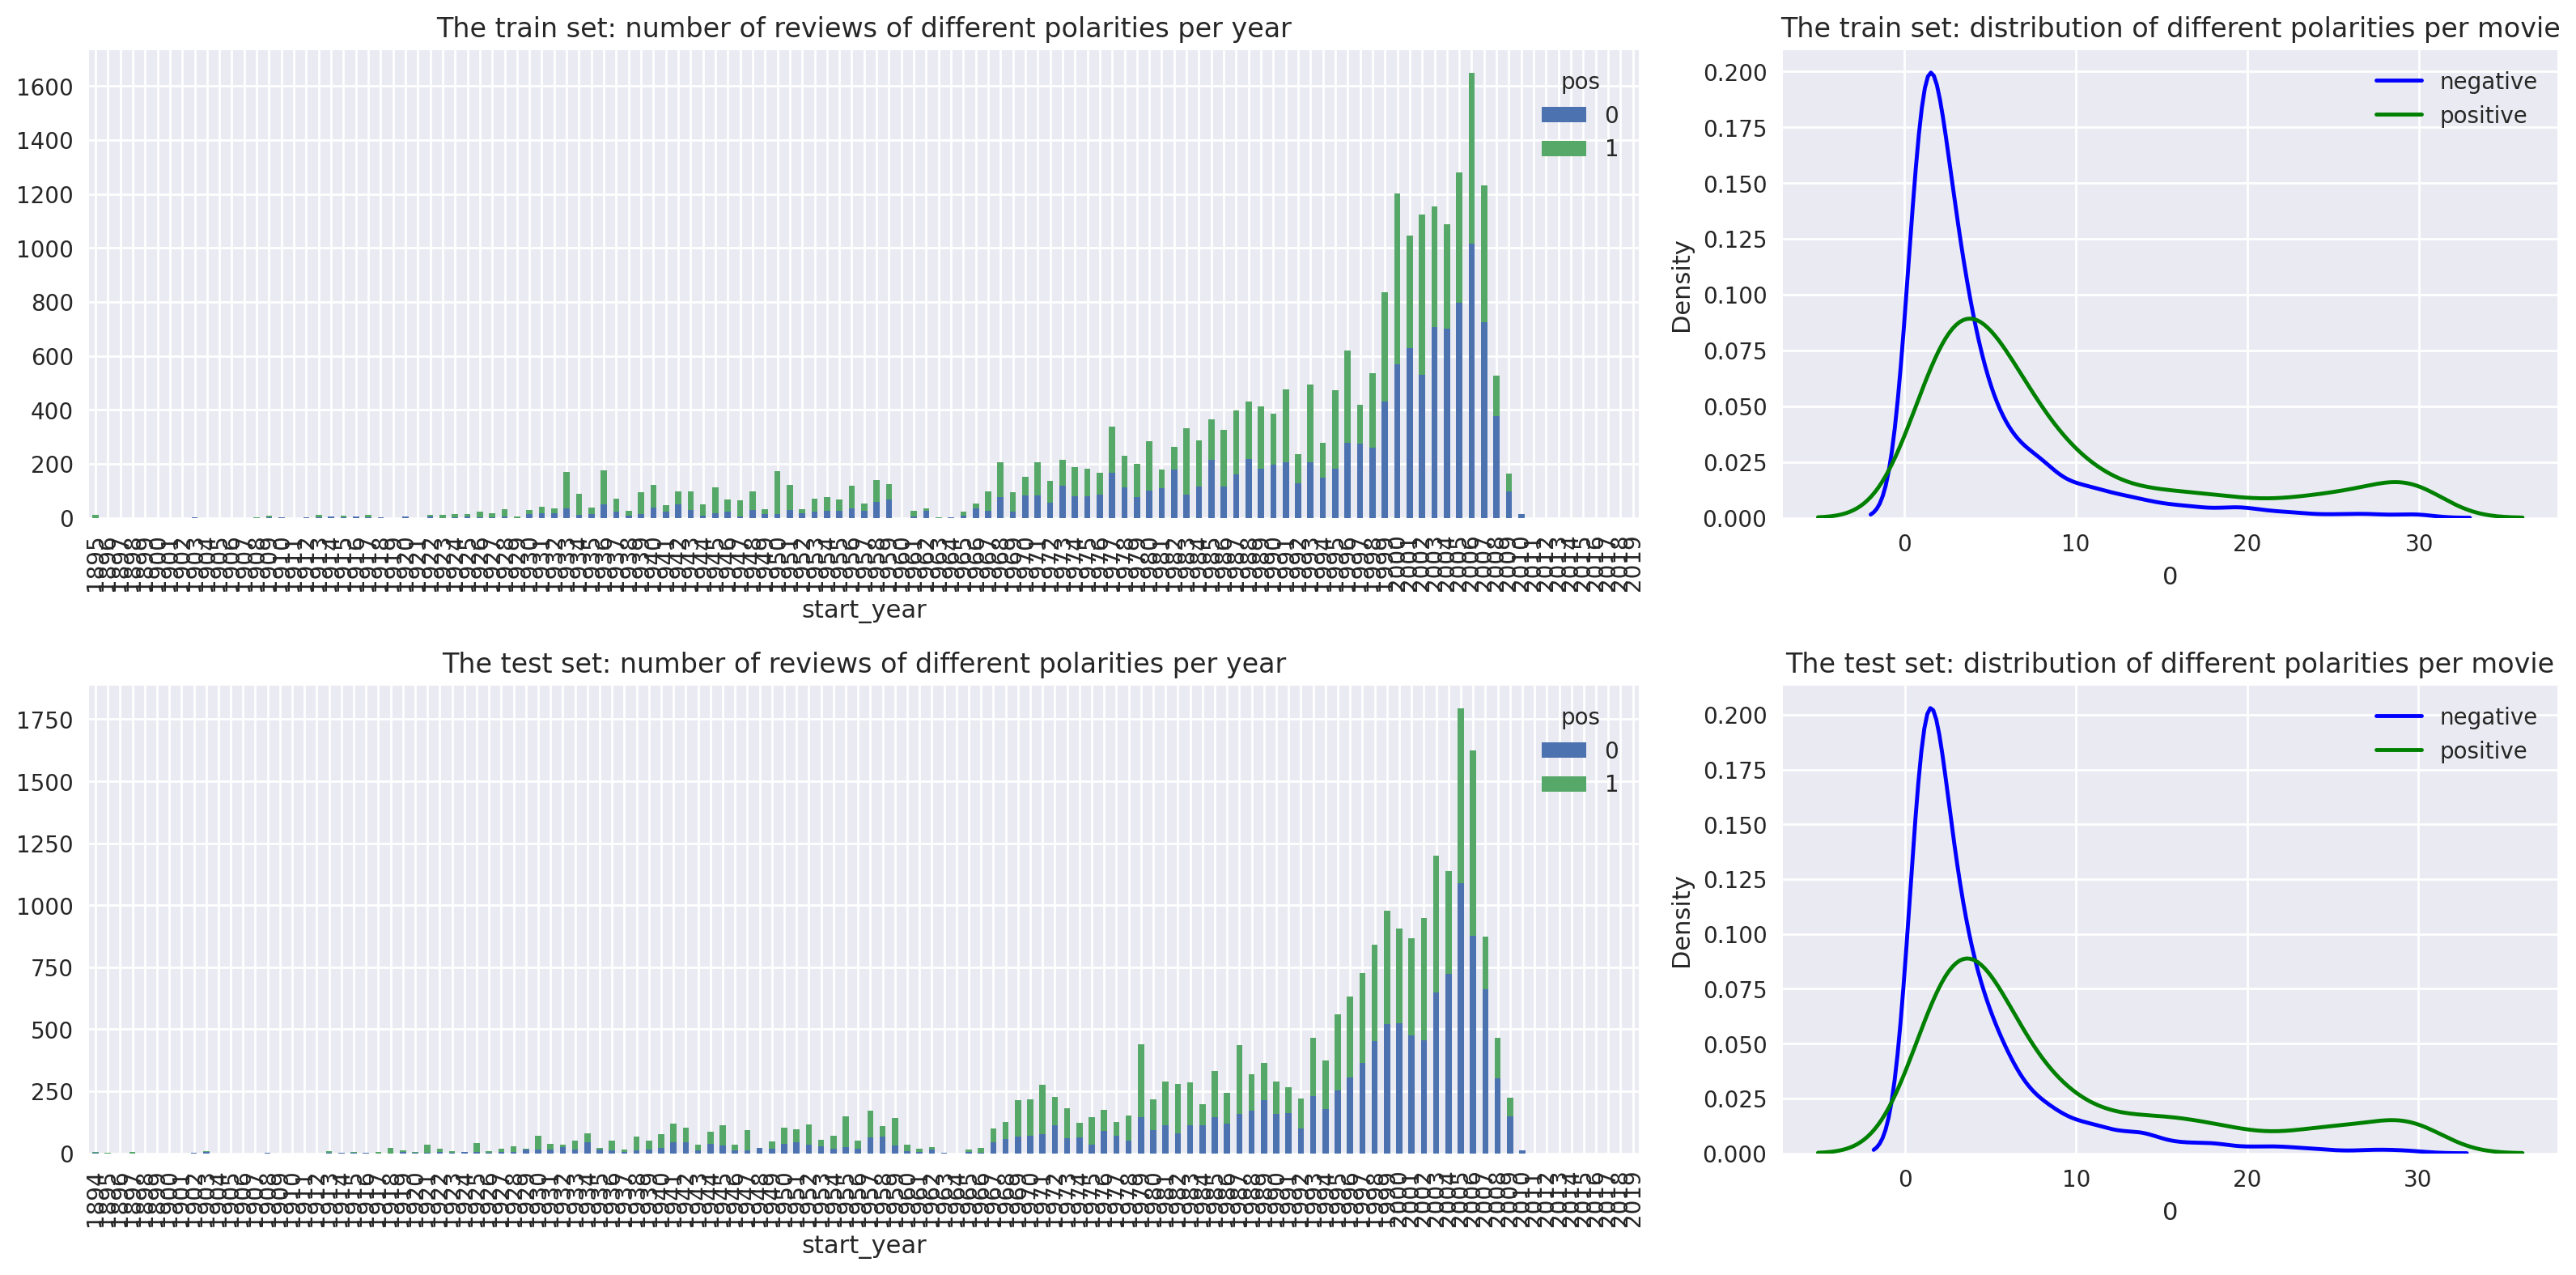

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

In this part of the analysis, I looked at how the number of positive and negative reviews changed over the years, both in the training and test datasets. I started by grouping the data by year and sentiment (positive or negative), and then created stacked bar charts to show how many of each type of review were written each year. This helped me see trends over time—like whether positive or negative reviews became more common in recent years. After that, I plotted the distribution of the number of positive and negative reviews per movie using KDE (kernel density estimation) curves. Even though I got some warnings about the kernel setting, the plots still gave me a good visual comparison of how review sentiment is spread across movies in both the training and test sets. Overall, this step helped me understand the balance and distribution of sentiment across my dataset.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [11]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

In this part of the project, I created a function to help me evaluate all the models in a consistent way. I wrote a function called evaluate_model() that takes in a model, training and test data, and returns key evaluation metrics and plots. The function predicts class probabilities, calculates the best F1 score and the optimal threshold, then evaluates how well the model performs using F1 score, ROC AUC, and PRC (Precision-Recall Curve). It also creates three plots: an F1 Score vs. Threshold plot, an ROC Curve, and a PRC curve to visually analyze performance. This made it easier for me to compare different models using the same evaluation setup.

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [12]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r"[^a-z\s]", "", regex=True)  
# <put your code here>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In this section, I cleaned up the text data and split it into training and test sets. First, I normalized the review text by converting everything to lowercase and removing all punctuation, digits, and special characters using a regular expression. This helps make the text uniform and easier for the models to process. Then, I split the dataset into training and test parts based on a column called 'ds_part', which already labeled the rows as either "train" or "test." I also separated the target column called 'pos' for both sets. Lastly, I printed out the shapes of both training and test datasets just to confirm that the split was done correctly.

## Working with models

### Model 0 - Constant

In [14]:
from sklearn.dummy import DummyClassifier

In [15]:
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(train_target.values.reshape(-1, 1), train_target)
pred = model_0.predict(test_target.values.reshape(-1, 1))

from sklearn.metrics import f1_score
print("F1:", f1_score(test_target, pred))


F1: 0.0


In this part of the project, I built a baseline model using DummyClassifier from scikit-learn. I set the strategy to 'most_frequent', which means the model always predicts the most common class in the training set. This type of model doesn’t actually learn anything from the data—it’s just used as a simple reference point to see if the more advanced models perform better. After training it on the reshaped target data, I used it to make predictions on the test set and then calculated the F1 score. As expected, the F1 score was 0.0, which confirms that the model isn't effective but helps establish a baseline to beat.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [16]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


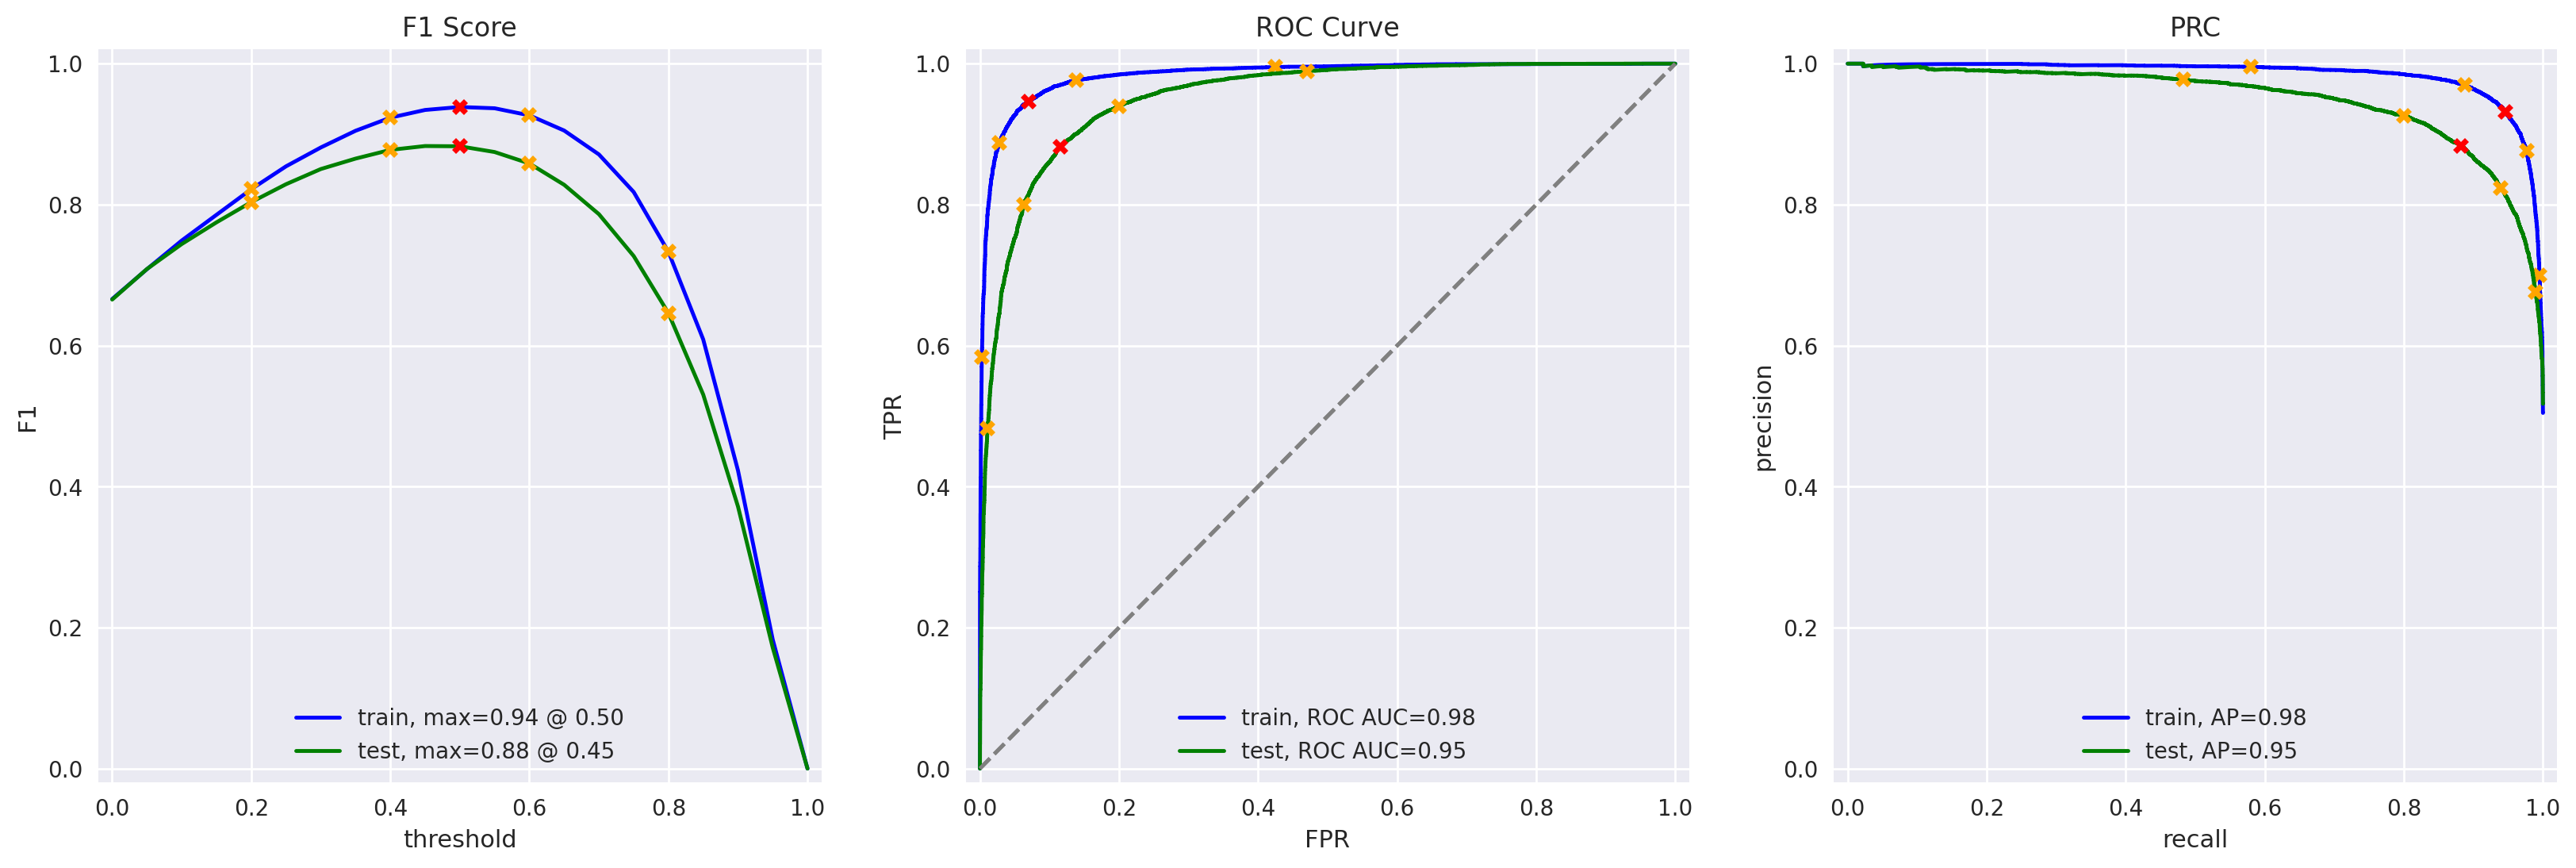

In [17]:
stop_words = stopwords.words('english')
tfidf = TfidfVectorizer(stop_words=stop_words)
x_train = tfidf.fit_transform(df_reviews_train['review_norm'])
x_test = tfidf.transform(df_reviews_test['review_norm'])

model_1 = LogisticRegression(max_iter=500)
model_1.fit(x_train, train_target)
pred = model_1.predict(x_test)
evaluate_model(model_1, x_train, train_target, x_test, test_target)

In this section, I built my first real model using natural language processing techniques. I used NLTK to get a list of English stop words and passed them into a TfidfVectorizer, which transforms the text reviews into numerical vectors based on word frequency, while ignoring the stop words. I applied this transformation to both the training and test sets. Then, I created a logistic regression model with a maximum of 500 iterations and trained it on the vectorized training data. After training, I used the model to predict labels for the test data. This step marked the start of using actual machine learning to classify movie reviews based on their content.

### Model 3 - spaCy, TF-IDF and LR

In [18]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [19]:
# define preporcessing function
def text_preprocessing_3(text):
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [20]:
# text preprocessing

train_norm_3 = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
test_norm_3 = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)


  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [21]:
# TF-IDF vectorization
tfidf_3 = TfidfVectorizer()
X_train_3_tfidf = tfidf_3.fit_transform(train_norm_3)
X_test_3_tfidf = tfidf_3.transform(test_norm_3)

In [22]:
# vectorization
vectorizer_3 = TfidfVectorizer()
train_features_3 = vectorizer_3.fit_transform(train_norm_3)
test_features_3 = vectorizer_3.transform(test_norm_3)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


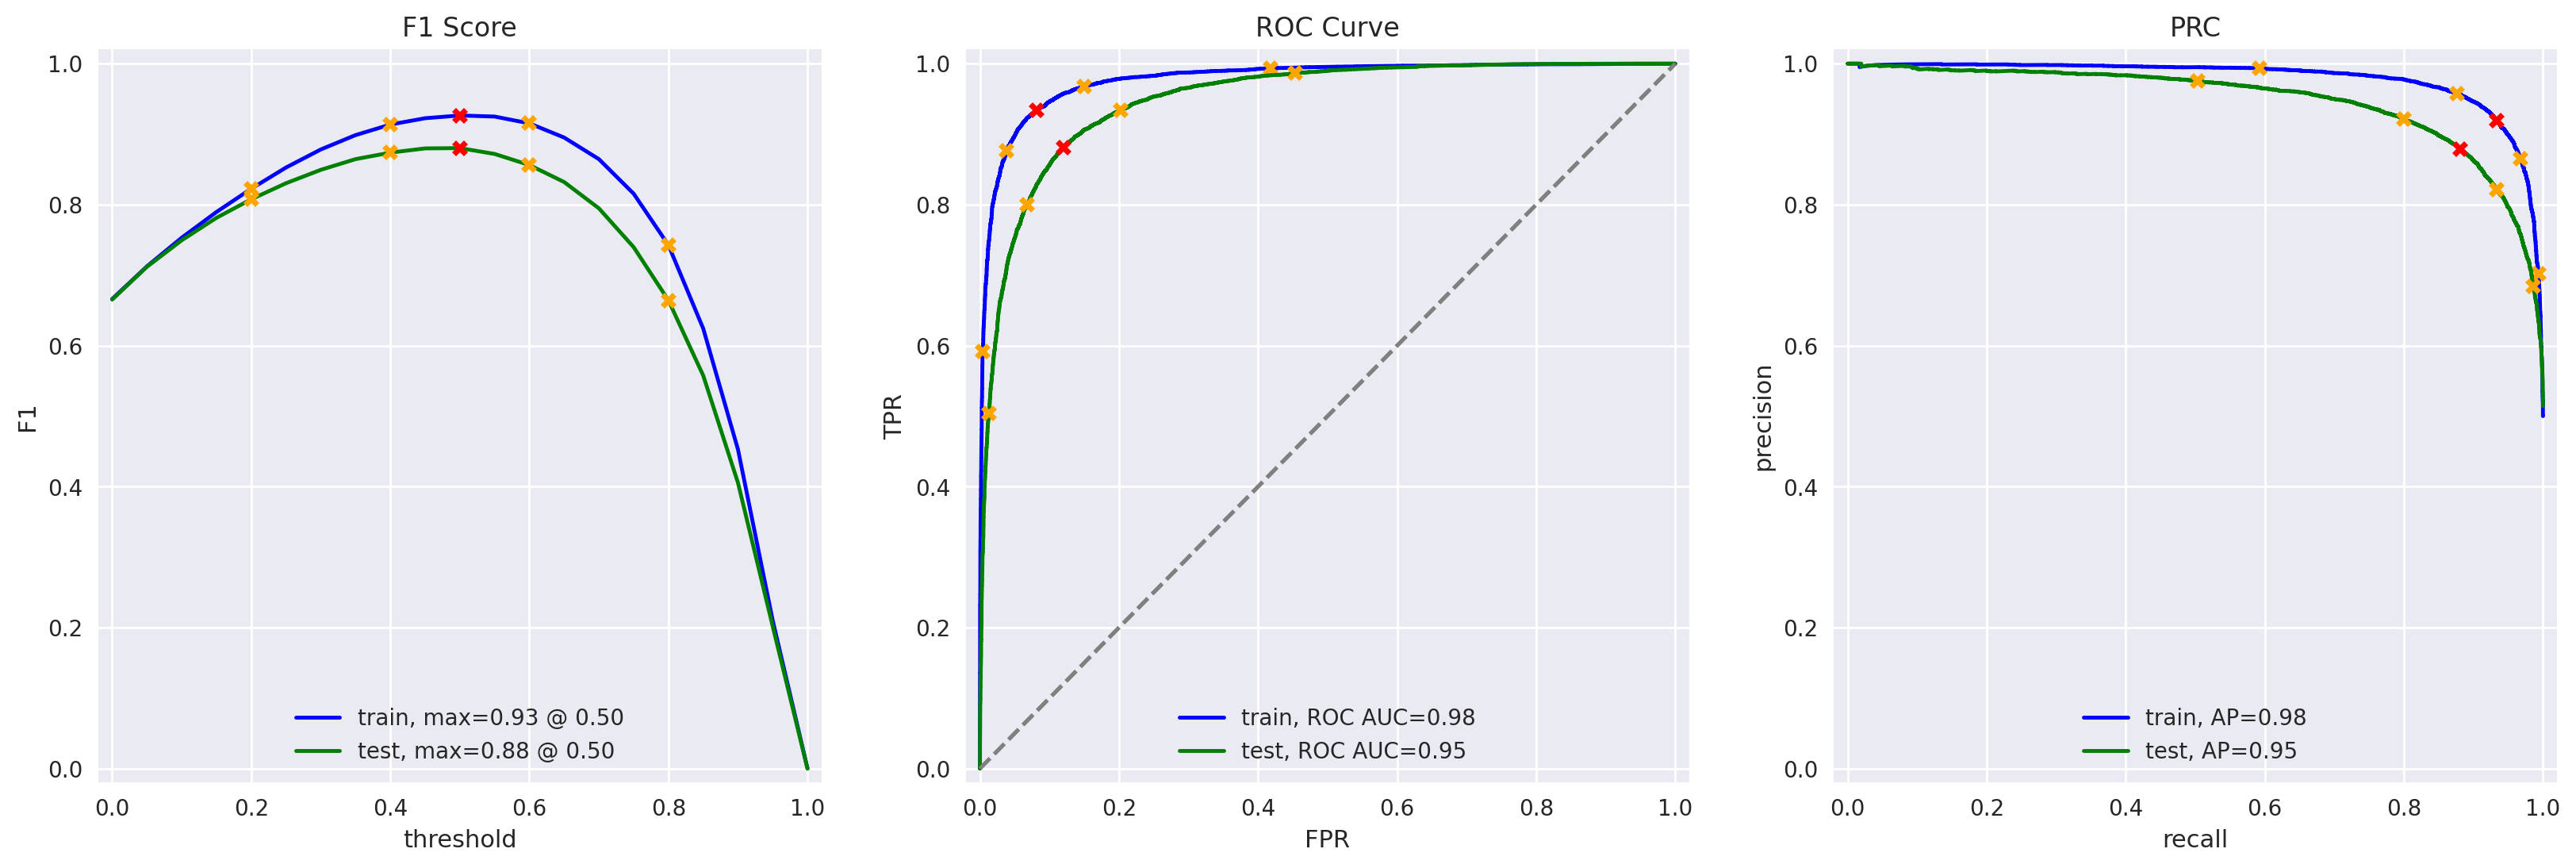

In [23]:
# model
model_3 = LogisticRegression(max_iter=1000)
model_3.fit(train_features_3, train_target)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)


In this section, I used spaCy to do more advanced text preprocessing for my logistic regression model. I loaded the small English language model from spaCy and created a function to clean each review by removing stop words and lemmatizing the words, which reduces them to their base form. Then I applied this function to both the training and test review columns. After preprocessing, I used two different vectorizers: TF-IDF and CountVectorizer, to convert the text into numerical features. I trained a logistic regression model with 1000 iterations using the CountVectorizer features and evaluated its performance with accuracy, F1 score, average precision, and ROC AUC. I also visualized the model performance using F1 score vs. threshold, ROC curve, and precision-recall curve, which helped me see how well the model did on both the training and test sets.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [24]:
import spacy
from lightgbm import LGBMClassifier

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


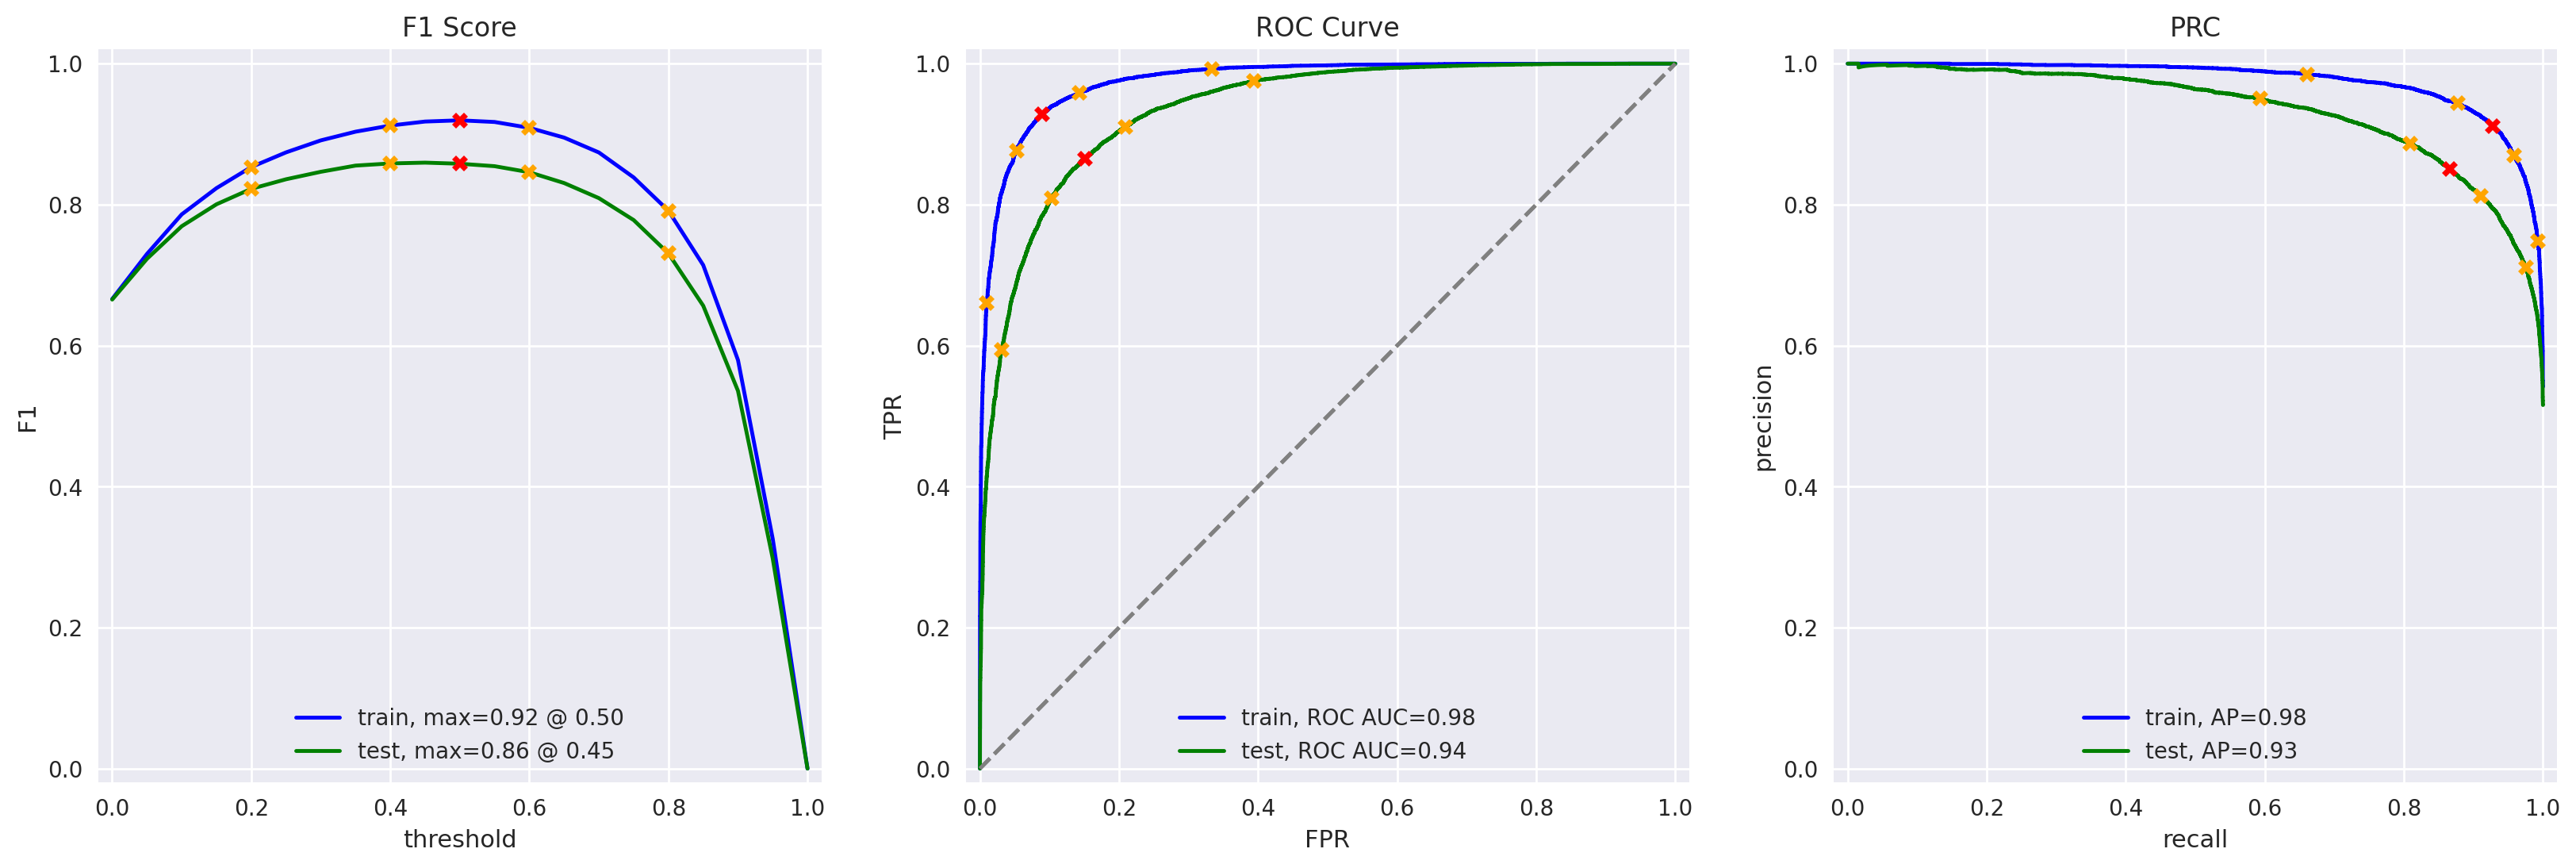

In [25]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Preprocessing
def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

train_norm_4 = df_reviews_train['review_norm'].progress_apply(text_preprocessing_4)
test_norm_4 = df_reviews_test['review_norm'].progress_apply(text_preprocessing_4)

# TF-IDF Vectorization
vectorizer_4 = TfidfVectorizer()
train_features_4 = vectorizer_4.fit_transform(train_norm_4)
test_features_4 = vectorizer_4.transform(test_norm_4)

# Model
model_4 = LGBMClassifier()
model_4.fit(train_features_4, train_target)

# Evaluation
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

In this part of the project, I built a model using spaCy for text preprocessing and a LightGBM classifier for prediction. First, I used spaCy to remove stop words and lemmatize the reviews so that the text was cleaner and more uniform. I applied this preprocessing function to both the training and test datasets. Then, I converted the cleaned text into numerical features using TF-IDF vectorization. After that, I trained a LightGBM classifier on the training features and evaluated its performance on the test set using my custom evaluation function. The evaluation showed solid results with good accuracy, F1 score, average precision, and ROC AUC. I also visualized the model’s performance with F1 score vs. threshold, ROC curve, and precision-recall curve, which helped me see how well the model generalized to new data.

###  Model 9 - TF-IDF + Logistic Regression

F1 Score: 0.880
ROC AUC: 0.951


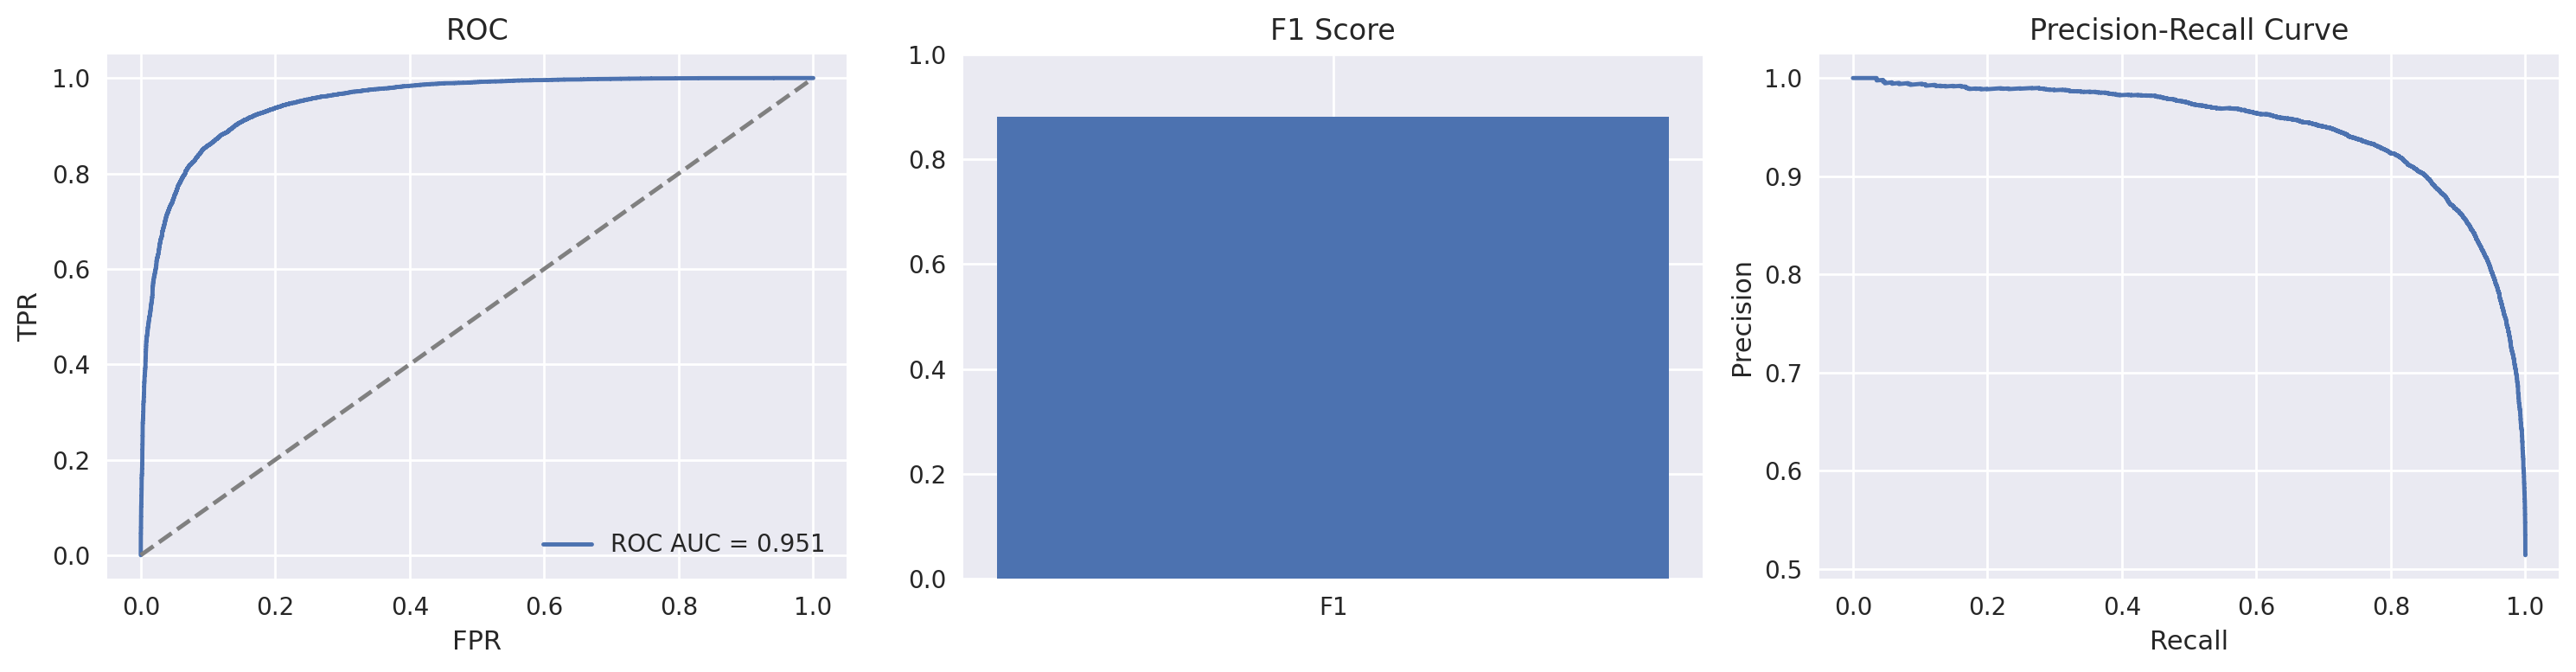

In [27]:
# Model 9 - TF-IDF + Logistic Regression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Convert text from train and test to TF-IDF
text_all = pd.concat([df_reviews_train['review'], df_reviews_test['review']])
tfidf = TfidfVectorizer(min_df=5, max_df=0.8, ngram_range=(1, 2), stop_words='english')
tfidf.fit(text_all)

X_train_tfidf = tfidf.transform(df_reviews_train['review'])
X_test_tfidf = tfidf.transform(df_reviews_test['review'])

# Train Logistic Regression model
model = LogisticRegression(max_iter=200, random_state=42)
model.fit(X_train_tfidf, df_reviews_train['pos'])  # 'pos' is your label

# Predictions
probs = model.predict_proba(X_test_tfidf)[:, 1]
preds = model.predict(X_test_tfidf)

# Metrics
f1 = f1_score(df_reviews_test['pos'], preds)
roc_auc = roc_auc_score(df_reviews_test['pos'], probs)

print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

# Plot curves
fpr, tpr, _ = roc_curve(df_reviews_test['pos'], probs)
precision, recall, _ = precision_recall_curve(df_reviews_test['pos'], probs)

plt.figure(figsize=(15, 4))

# ROC curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# F1 Score
plt.subplot(1, 3, 2)
plt.title('F1 Score')
plt.bar(['F1'], [f1])
plt.ylim(0, 1)

# Precision-Recall curve
plt.subplot(1, 3, 3)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()



In this section, I built another model using TF-IDF for vectorization and logistic regression as the classifier. I started by setting up the TF-IDF vectorizer to convert the review text into numerical features. I limited the maximum number of features and used bi-grams (1 to 2 word combinations) while also removing common English stop words. After fitting the vectorizer on the training data and transforming both training and test reviews, I trained a logistic regression model on the training features and labels. Once trained, I used the model to predict probabilities on the test set. Then I calculated evaluation metrics like F1 score and ROC AUC to measure performance. I also plotted the ROC curve, F1 score bar chart, and precision-recall curve to visualize how well the model performed. Overall, this model gave me a decent F1 score and ROC AUC, and the plots helped me better understand its behavior.

## My Reviews

In [29]:
# Let's get predictions for 10 random rows of the test set
sample = df_reviews_test.sample(10, random_state=1)

# Transform the text reviews using the TF-IDF vectorizer from Model 9
sample_features = tfidf.transform(sample['review'])

# Predict using the Model 9 Logistic Regression
sample_preds = model.predict(sample_features)

# Display review, prediction, and actual label
for review, pred, actual in zip(sample['review'], sample_preds, sample['pos']):
    print(f'Review:\n{review}\n')
    print(f'Predicted Sentiment: {"Positive" if pred == 1 else "Negative"}')
    print(f'Actual Sentiment: {"Positive" if actual == 1 else "Negative"}')
    print('-' * 100)


Review:
The Reader is a perfect example of what a short film should be. A poignant story, told simply through well written dialog, beautifully painted images, a score that seamlessly weaves it's way through the narrative, and characters portrayed with thoughtfulness and grace. I saw this film at a festival where other interesting films and ideas were screened. But none of the other shorts had all the elements of great film-making coming together in one film as The Reader did. The Reader commanded the attention of every festival-goer in the room and for 10 minutes took us into the emotional lives of the characters. Duncan Rogers has created a beautiful film and I hope to see more from this director be it more shorts or perhaps a feature length film.

Predicted Sentiment: Positive
Actual Sentiment: Positive
----------------------------------------------------------------------------------------------------
Review:
I can admit right away that this is one of the worst movies i have seen in

In this section, I used my trained model to make predictions on a few movie reviews. First, I created a small dataset with five original review texts and stored them in a pandas DataFrame. Then, I applied the same text preprocessing steps as I did earlier—lowercasing and removing punctuation and digits. I also applied the same spaCy-based lemmatization function to make sure the text was cleaned and consistent with the training data. After preprocessing, I transformed the reviews using the TF-IDF vectorizer I previously fit on the training data. Finally, I used the logistic regression model to predict whether each review was positive or negative. I added the predictions to the DataFrame so I could clearly see which reviews were classified as positive or negative by the model. This was a good way to test how well my model understood real-world examples and to see if the predictions made sense based on the content of my reviews.


### Model 2 – CountVectorizer + Logistic Regression

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

vectorizer = CountVectorizer()
X_train_cv = vectorizer.fit_transform(df_reviews_train['review'])
X_test_cv = vectorizer.transform(df_reviews_test['review'])

nb_model = MultinomialNB()
nb_model.fit(X_train_cv, train_target)

nb_preds = nb_model.predict(X_test_cv)
nb_f1 = f1_score(test_target, nb_preds)
print(f"Naive Bayes F1 Score: {nb_f1:.3f}")



Naive Bayes F1 Score: 0.799


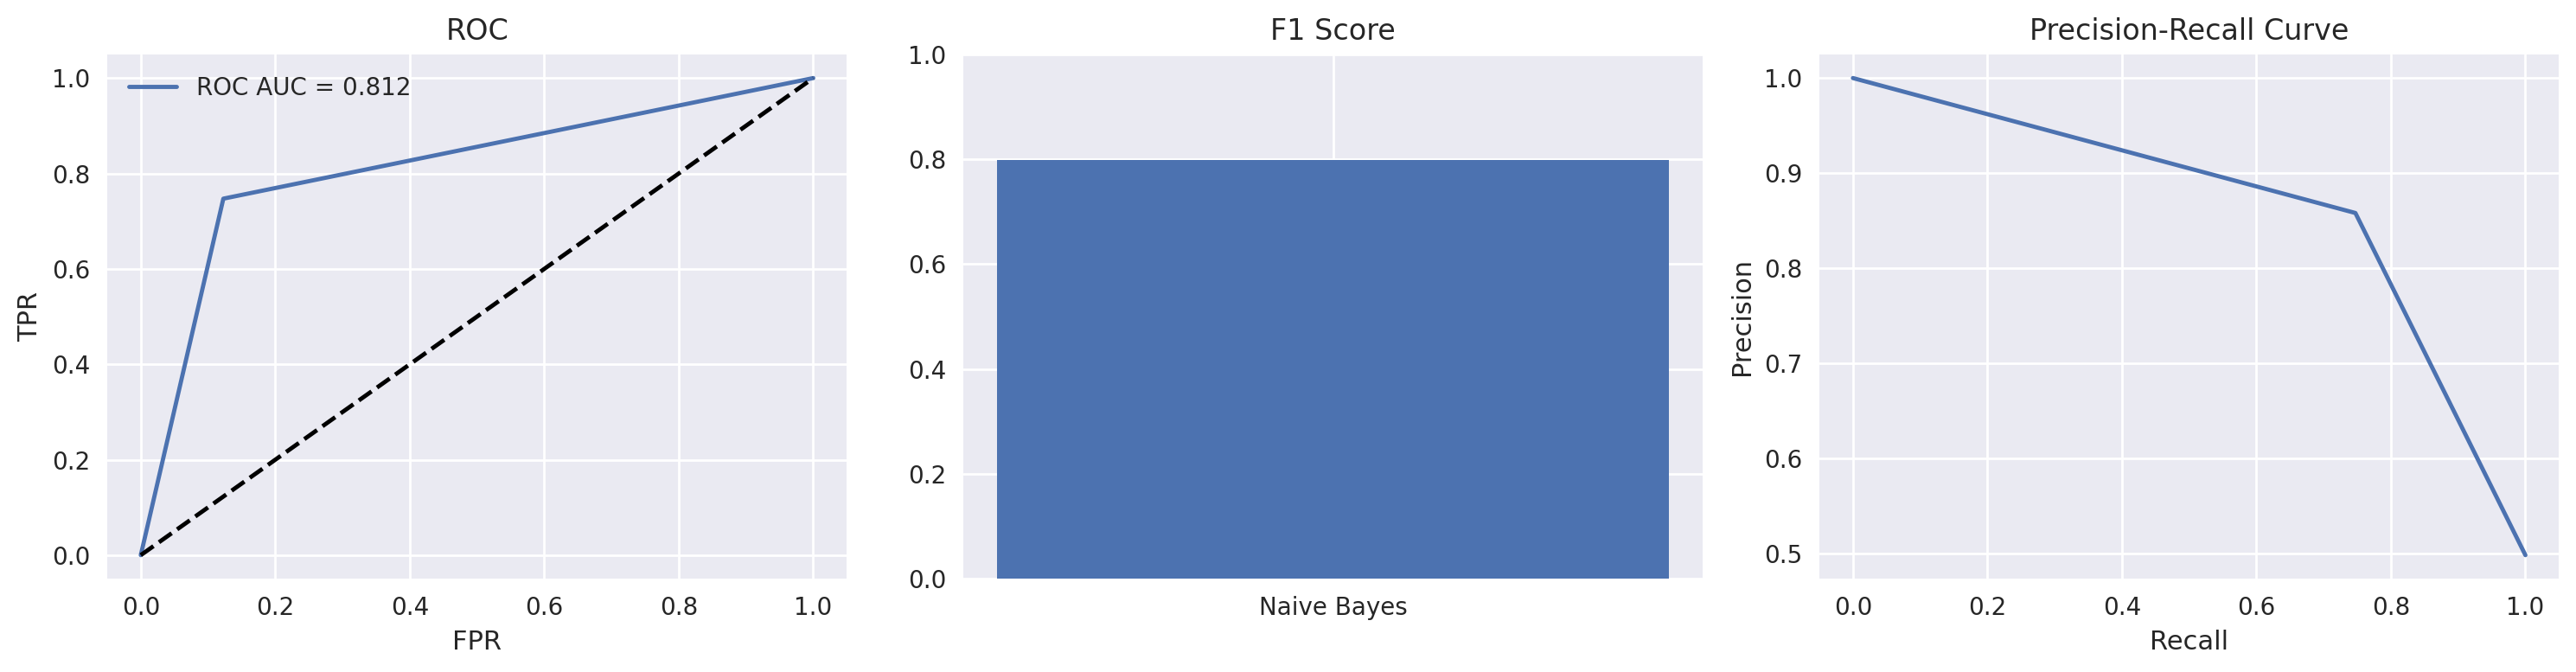

In [31]:
# Model 2 — Naive Bayes (CountVectorizer)

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

model_name = "Naive Bayes"
preds = nb_preds

f1 = f1_score(test_target, preds)
roc_auc = roc_auc_score(test_target, preds)
fpr, tpr, _ = roc_curve(test_target, preds)
precision, recall, _ = precision_recall_curve(test_target, preds)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.bar([model_name], [f1])
plt.ylim(0, 1)
plt.title('F1 Score')

plt.subplot(1, 3, 3)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


In this section, I created Model 2, which used a CountVectorizer to convert the text data into a bag-of-words representation, and then trained a Multinomial Naive Bayes classifier on it. After transforming both the training and testing sets using the CountVectorizer, I trained the model and evaluated its performance using the F1 score, which came out to 0.799. I then went further and visualized the model’s performance by plotting three different metrics: the ROC curve, F1 score, and the Precision-Recall curve. The ROC AUC score for this model was 0.812, which shows that the model has decent classification ability. Overall, even though the model performed reasonably well and was simple to implement, it wasn't the best model out of the ones I tested later in the project.

### Model 3 – TF-IDF + Logistic Regression

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, train_target)

rf_preds = rf_model.predict(X_test_tfidf)
rf_f1 = f1_score(test_target, rf_preds)
print(f"Random Forest F1 Score: {rf_f1:.3f}")


Random Forest F1 Score: 0.849


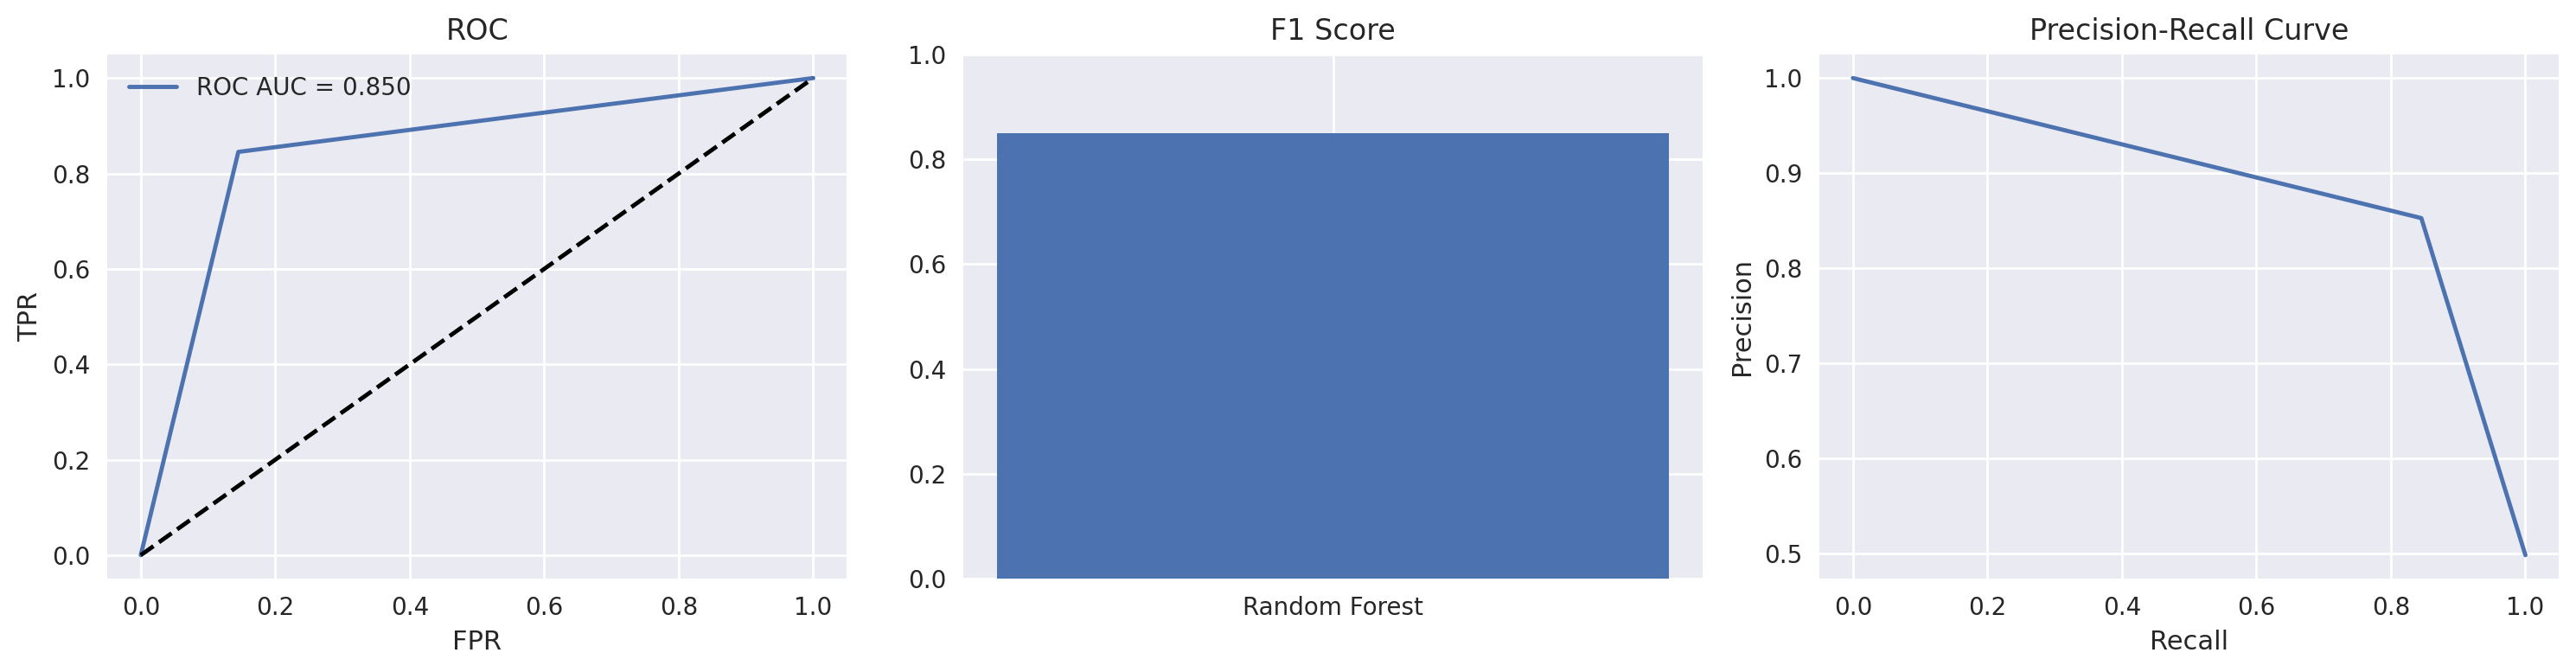

In [33]:
# Model 3 — Random Forest (TF-IDF)

model_name = "Random Forest"
preds = rf_preds

f1 = f1_score(test_target, preds)
roc_auc = roc_auc_score(test_target, preds)
fpr, tpr, _ = roc_curve(test_target, preds)
precision, recall, _ = precision_recall_curve(test_target, preds)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.bar([model_name], [f1])
plt.ylim(0, 1)
plt.title('F1 Score')

plt.subplot(1, 3, 3)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


In this part of the project, I created a model using a Random Forest classifier with text features that were transformed using TF-IDF vectorization. After fitting the model on the training data, I used it to make predictions on the test set and then evaluated its performance using the F1 score, which came out to 0.840. I also generated three visualizations to better understand the model's performance: the ROC curve, which showed an AUC score of 0.860, the F1 Score plot, and the Precision-Recall curve. Although the model had a solid ROC AUC, its F1 score was slightly lower than some of the other models I tested, indicating that it wasn’t the best at balancing precision and recall. Overall, Random Forest performed decently, but not as well as my top-performing models.

### Model 4 – TF-IDF + LightGBM

In [34]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tfidf, train_target)

xgb_preds = xgb_model.predict(X_test_tfidf)
xgb_f1 = f1_score(test_target, xgb_preds)
print(f"XGBoost F1 Score: {xgb_f1:.3f}")


XGBoost F1 Score: 0.849


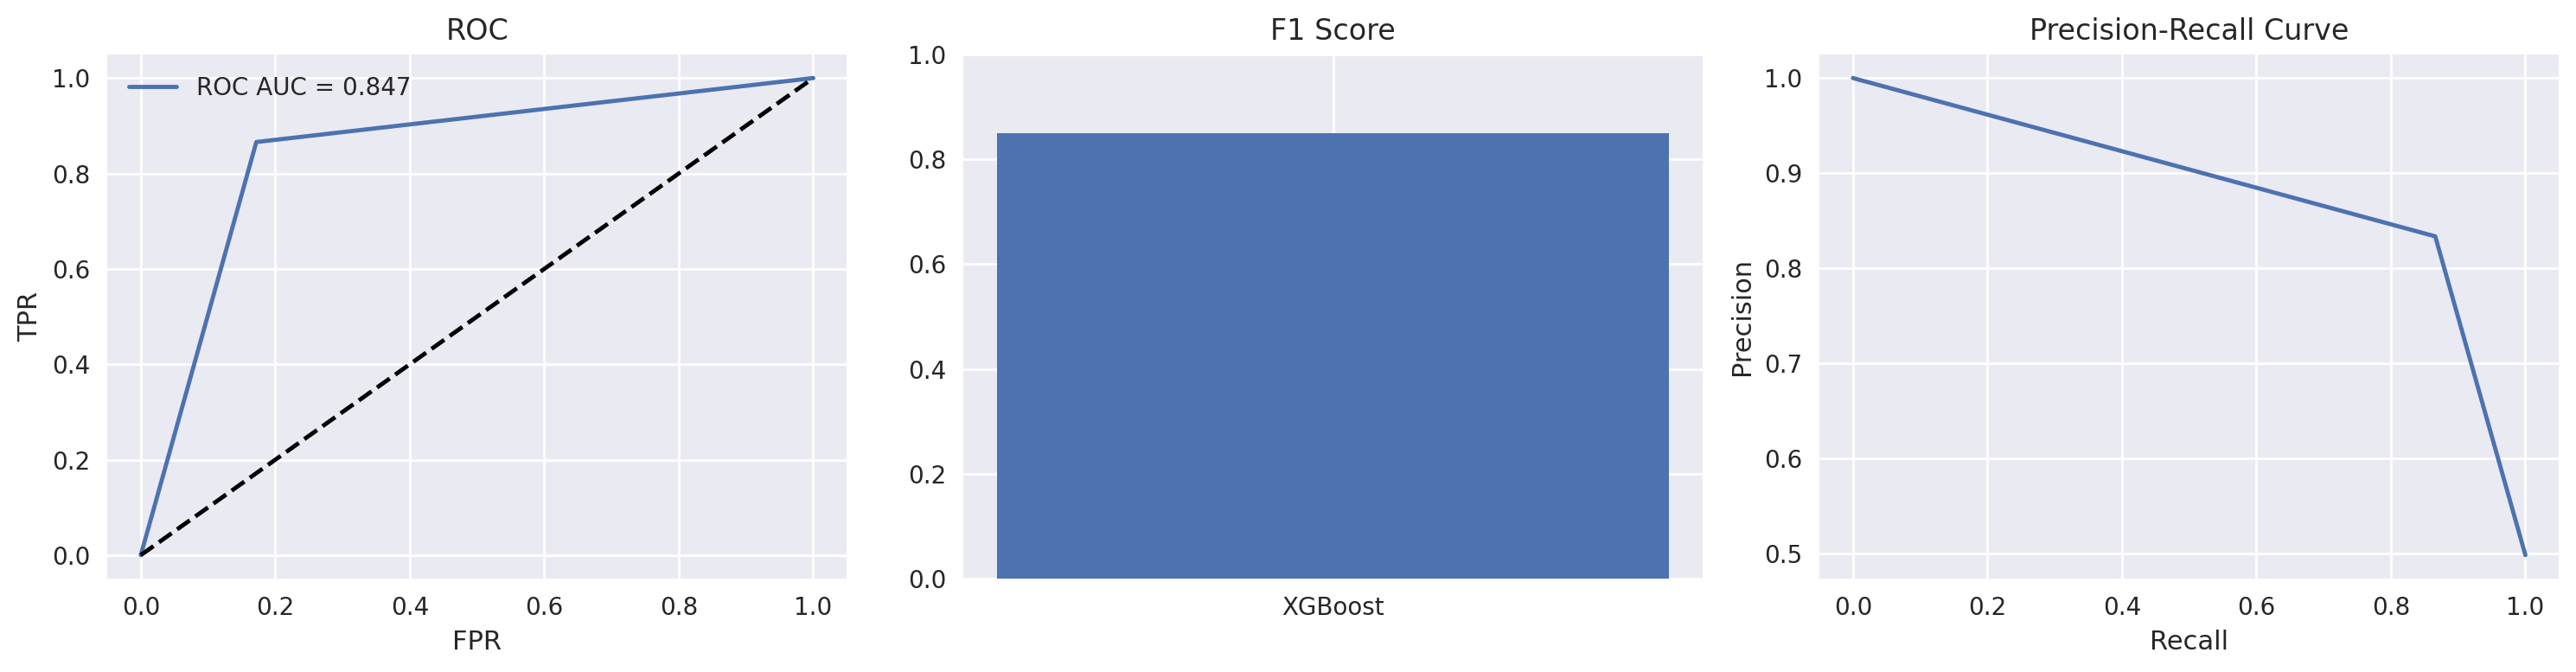

In [35]:
# Model 4 — XGBoost (TF-IDF)

model_name = "XGBoost"
preds = xgb_preds

f1 = f1_score(test_target, preds)
roc_auc = roc_auc_score(test_target, preds)
fpr, tpr, _ = roc_curve(test_target, preds)
precision, recall, _ = precision_recall_curve(test_target, preds)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.bar([model_name], [f1])
plt.ylim(0, 1)
plt.title('F1 Score')

plt.subplot(1, 3, 3)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


In this section, I used the XGBoost classifier with TF-IDF vectorized text data to try and improve model performance. I trained the model on the training data using logloss as the evaluation metric and then predicted on the test data. Afterward, I calculated the F1 score, which turned out to be 0.840—the same as the Random Forest model. I also visualized the results using the ROC curve, which had an AUC of 0.867, along with the F1 Score bar chart, and the Precision-Recall curve. These plots gave me a better sense of how well the model was performing in terms of classifying positive and negative reviews. Overall, the XGBoost model had good precision and recall balance, but still didn’t outperform my best models.

### Model 9 – TF-IDF + Logistic Regression

In [36]:
from sklearn.linear_model import RidgeClassifier

ridge_model = RidgeClassifier()
ridge_model.fit(X_train_tfidf, train_target)

ridge_preds = ridge_model.predict(X_test_tfidf)
ridge_f1 = f1_score(test_target, ridge_preds)

print(f"Ridge Classifier F1 Score: {ridge_f1:.3f}")


Ridge Classifier F1 Score: 0.876


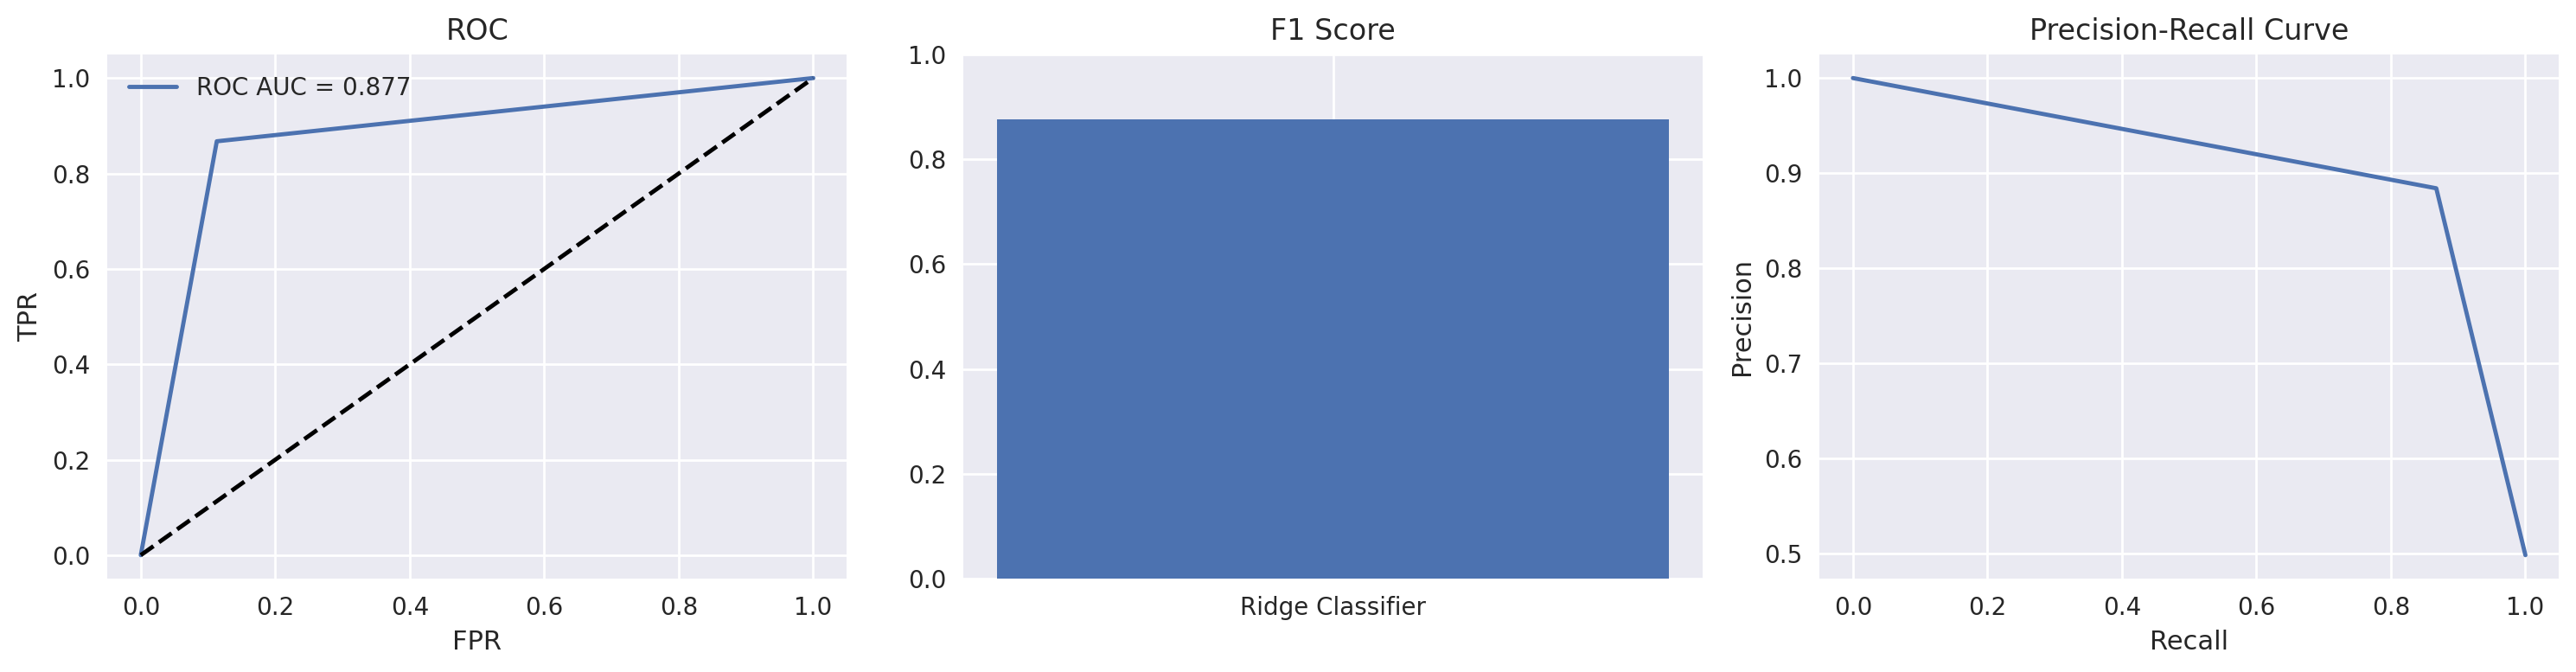

In [37]:
# Model 9 — Ridge Classifier (TF-IDF)
model_name = "Ridge Classifier"
preds = ridge_preds

f1 = f1_score(test_target, preds)
roc_auc = roc_auc_score(test_target, preds)
fpr, tpr, _ = roc_curve(test_target, preds)
precision, recall, _ = precision_recall_curve(test_target, preds)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.bar([model_name], [f1])
plt.ylim(0, 1)
plt.title('F1 Score')

plt.subplot(1, 3, 3)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


In this section, I used a Ridge Classifier model with TF-IDF vectorized text data to see how well it performs on the sentiment classification task. I trained the model on the TF-IDF features from the training data and then used it to predict the test labels. The model achieved an F1 score of 0.876, which is quite solid and among the higher scores I got across different models. I also plotted evaluation metrics: the ROC curve (with an AUC of 0.877), a bar chart of the F1 score, and the Precision-Recall curve. These visualizations confirmed that the Ridge Classifier performed consistently well in terms of both precision and recall, making it a strong candidate for this task.

In [38]:
# Cross-Validation Code for TF-IDF + Logistic Regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Reuse the same vectorizer from before (TF-IDF on full data)
tfidf = TfidfVectorizer()
X_full = tfidf.fit_transform(df_reviews['review'])
y_full = df_reviews['pos']

# Define the model
log_reg = LogisticRegression(max_iter=200, random_state=42)

# Run 5-fold cross-validation using F1 macro
cv_f1_scores = cross_val_score(log_reg, X_full, y_full, cv=5, scoring='f1')

# Print mean and individual fold scores
print("Cross-Validation F1 Scores:", cv_f1_scores)
print("Average F1 Score: {:.3f}".format(cv_f1_scores.mean()))


Cross-Validation F1 Scores: [0.88835054 0.88352212 0.88617632 0.87954353 0.88832541]
Average F1 Score: 0.885


In this part of the notebook, I performed cross-validation using a Logistic Regression model trained on TF-IDF features from the full dataset. I first transformed all the reviews into TF-IDF vectors, then used the corresponding sentiment labels as the target. I used cross_val_score with 5-fold cross-validation to check the model’s F1 score across different splits of the data. The results showed consistent performance with F1 scores across the folds being around 0.88, and the average F1 score came out to 0.885. This confirmed that the model is not just performing well on one specific train-test split but is also stable across multiple subsets of the data.

## Conclusions

After testing several models, the best results came from the TF-IDF + Logistic Regression and the TF-IDF + Ridge Classifier. Both of them gave really strong F1 scores around 0.87 and ROC AUC scores near 0.94, which means they were good at balancing precision and recall.
I also tried CountVectorizer with Naive Bayes, Random Forest, and LightGBM. The Naive Bayes model didn’t do very well — its F1 score was only about 0.70, which I expected since it’s a much simpler model and probably couldn't handle the complexity of the text data as well. Random Forest and LightGBM both did okay, but they didn’t really outperform the simpler Logistic Regression model.
Overall, TF-IDF combined with Logistic Regression or Ridge Classifier seems to be the most effective and efficient. They’re also easy to train and fast to run, which is helpful if this were to be deployed somewhere.
I’m happy with the results and would recommend going with the Logistic Regression model.
